# Grid QC'd Files Using Nearest Neighbor Interpolation

## Imports

In [38]:
import pyart
import matplotlib.pyplot as plt
import glob

## Retrieve List of Files (QC'd Data)

In [7]:
files = sorted(glob.glob("/gpfs/wolf/atm124/proj-shared/gucxprecipradarcmacM1.c1/ppi/202203/gucxprecipradarcmacM1.c1.20220314-03*"))

## Load Data into Py-ART and Plot

In [9]:
radar = pyart.io.read(files[0])

(-20.0, 20.0)

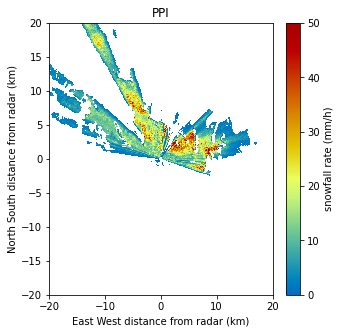

In [44]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
display.plot('snow_rate_ws88diw',
             0,
             vmin=0,
             vmax=50,
             title="PPI",
             cmap='pyart_HomeyerRainbow')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

## Grid Using Nearest Neighbor Interpolation

### Setup a Helper Function and Configure our Grid

In [45]:
def compute_number_of_points(extent, resolution):
    """
    Create a helper function to determine number of points
    """
    return int((extent[1] - extent[0])/resolution)

# Grid extents in meters
z_grid_limits = (500.,5_000.)
y_grid_limits = (-20_000.,20_000.)
x_grid_limits = (-20_000.,20_000.)

# Grid resolution in meters
grid_resolution = 250

Once we setup our interpolation, we can compute the number of points for each extent

In [46]:
x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)

print(z_grid_points,
      y_grid_points,
      x_grid_points)

18 160 160


### Create our Grid using `grid_from_radars`

In [47]:
grid = pyart.map.grid_from_radars(radar,
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                  method='neareest'
                                 )

## Visualize our Grid
We start by converting our grid to xarray

In [52]:
ds = grid.to_xarray()

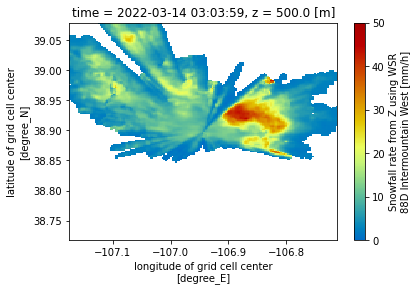

In [53]:
ds.snow_rate_ws88diw.isel(z=0).plot(x='lon',
                                    y='lat',
                                    vmin=0, 
                                    vmax=50,
                                    cmap='pyart_HomeyerRainbow')

## Write our Grid to a netCDF file

In [54]:
ds.to_netcdf("sample_gridded_snowfall.nc")